# A Pairs Trading strategy 

**Author:** Simão Moraes Sarmento <br /> 
**Contact:** simaosarmento@hotmail.com

## Dependencies

This notebook requires code from:

Python files:
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

Pickle files:
- pickle file containing pairs to be traded (obtained from running `PairsTrading_CommodityETFs-Clustering.ipynb`)

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples. Please look into the files menitoned above for more detailed info on how the functions are built.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# just set the seed for the random number generator
np.random.seed(107)

In [2]:
ticker_path = "data/etfs/pickle/ticker_segment_dict.pickle"
with open(ticker_path, 'rb') as handle:
    ticker_segment_dict = pickle.load(handle)

### Import Classes

In [5]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor
%autoreload 1

In [6]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()

# Retrieve prices data set

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [7]:
# intraday
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_from_2014_complete.pickle')

In [8]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            ('01-01-2013',
                                                             '31-12-2015'),
                                                            ('01-01-2016',
                                                             '31-12-2016'),
                                                            remove_nan=True)

Total of 116 tickers
Total of 105 tickers after removing tickers with Nan values


In [9]:
len(df_prices_train)+len(df_prices_test)

78222

# Load Pairs

In [10]:
#with open('data/etfs/pickle/2013-2017/pairs_unsupervised_learning_optical_intraday.pickle', 'rb') as handle:
#    pairs = pickle.load(handle)

with open('data/etfs/pickle/2013-2017/pairs_unsupervised_learning_optical_intraday_p005_seed0.pickle',
          'rb') as handle:
    pairs = pickle.load(handle)

In [12]:
len(pairs)

40

# Apply trading strategies

**Applying the fixed beta strategy in validation period**

In [13]:
train_val_split = '2015-01-01'

# intraday
n_years_val = round(len(df_prices_train[train_val_split:])/(240*78))

# interday
#n_years_val = round(len(df_prices_train)/(240))

n_years_val

1

In [3]:
train_results_without_costs, train_results_with_costs, performance_threshold_train = \
        trader.apply_trading_strategy(pairs, 
                                       'fixed_beta',
                                        2,#entry_multiplier,
                                        0,#exit_multiplier,
                                        test_mode=False,
                                        train_val_split=train_val_split
                                       )

sharpe_results_threshold_train_nocosts, cum_returns_threshold_train_nocosts = train_results_without_costs
sharpe_results_threshold_train_w_costs, cum_returns_threshold_train_w_costs = train_results_with_costs

NameError: name 'trader' is not defined

Average SR:  1.4651719299145358
Annual ROI:  10.955581285166026
87.5 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  5.993791873075803
Autocorrelation:  -0.01074303996221513
Daily Sharpe Ratio 0.3588425755795638
Total number of trades:  157
Positive trades:  131
Negative trades:  26
Max DD period: 7.0 days
Maximum drawdown of portfolio: -0.55%


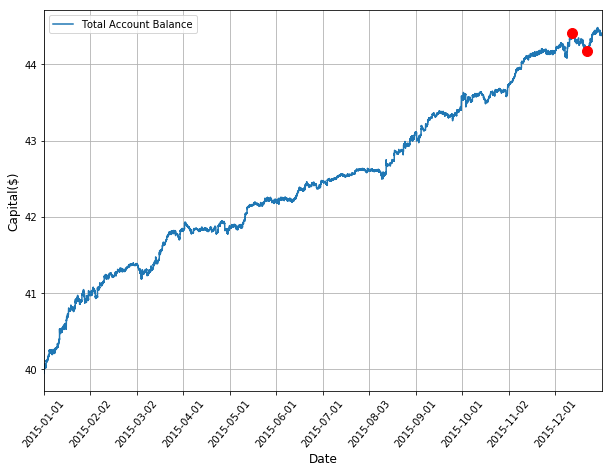

In [15]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_train_w_costs,
                                                  cum_returns_threshold_train_w_costs,
                                                  performance_threshold_train,
                                                  pairs, ticker_segment_dict,
                                                  n_years_val)

In [31]:
print('Corrected Annualized SR: {:.2f}'.format(0.3588425755795638*(252**0.5)))

Corrected Annualized SR: 5.70


Sharpe Ratio Distribution: 


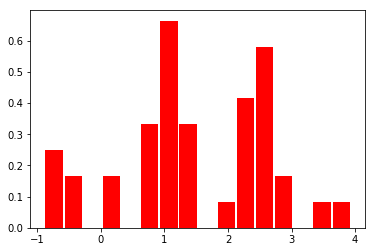

In [16]:
print('Sharpe Ratio Distribution: ')
n, bins, patches = plt.hist(sharpe_results_threshold_train_w_costs, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')

In [17]:
#cum_returns_threshold_train_w_costs

In [18]:
betas = list()
for i in range(len(pairs)):
    betas.append(pairs[i][2]['coint_coef'])
np.asarray(betas)

array([1.00065216, 1.85857758, 1.82650352, 2.38656782, 0.23761356,
       0.2322863 , 0.23963535, 2.43057765, 0.52140302, 0.21473549,
       0.2111986 , 1.40329718, 0.56564481, 0.13970543, 0.0562345 ,
       0.47041324, 0.41893223, 1.42913711, 0.57587538, 0.90244367,
       0.74707641, 0.34742619, 1.64568947, 0.40169478, 1.97136786,
       0.6740714 , 1.16529968, 0.66825491, 0.30150536, 0.44739192,
       0.77402251, 1.67031283, 0.46674424, 4.27945843, 1.95294305,
       0.66013011, 2.76642467, 0.71078962, 0.70179919, 1.06348963])

# Out of Sample Analysis

In this section, we analyze the performance of the strategy in the validation dataset. 

We proceed with some data exploration analysis. For this purpose we will do the following:

- Analyze which percentage of the identified pairs are still cointegrated in the validation period.
- Analyze which percentage of pairs have positive returns, and how many of those are still cointegrated.
- Analyze how many new pais were not identified to be cointegrated up to the validation period.
- Run strategy for identified pairs in training period.

This analysis will help us getting some insight into how the cointegrated pairs vary from time to time, and therefore how we should allocate our resources to predict when pairs are not cointegrated anymore.

## Applying the Strategy out-of Sample

We might want to apply the strategy in all pairs identified. Or, instead, we might prefer to apply the strategy only on those pairs that turned out to be profitable. Let's compare how both approaches work:

In [19]:
# intraday
n_years_test = round(len(df_prices_test)/(240*78))

# interday
#n_years_test = round(len(df_prices_test)/(240))

n_years_test

1

### Approach 1: Unrestricted

**Basic Threshold Strategy**

In [20]:
results_without_costs, results_with_costs, performance_threshold_test = \
                            trader.apply_trading_strategy(pairs, 
                                                           'fixed_beta',
                                                            2,#entry_multiplier,
                                                            0,#exit_multiplier,
                                                            test_mode=True,
                                                            train_val_split=train_val_split
                                                           )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 40/40

Average SR:  1.1498012443897472
Annual ROI:  10.500034839865148
80.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  4.977899210639678
Autocorrelation:  0.013103939916319758
Daily Sharpe Ratio 0.2972313225170644
Total number of trades:  87
Positive trades:  72
Negative trades:  15
Max DD period: 9.0 days
Maximum drawdown of portfolio: -0.80%


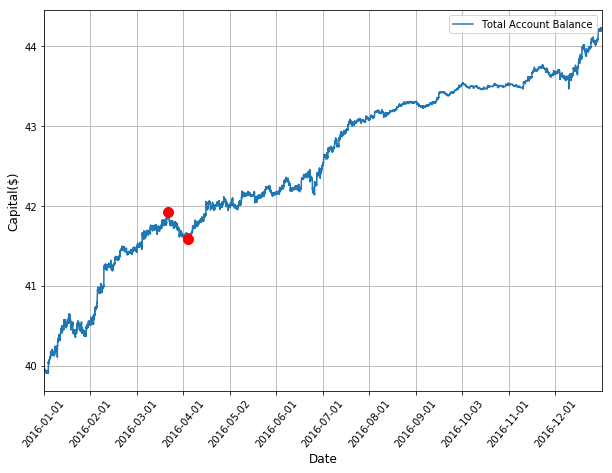

In [21]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  pairs, ticker_segment_dict,
                                                  n_years_test)

In [32]:
print('Corrected Annualized SR: {:.2f}'.format(0.2972313225170644*(252**0.5)))

Corrected Annualized SR: 4.72


### Approach 2: Keeping only pairs that had positive returns in the training period

In [22]:
cum_returns_threshold_train_w_costs = np.asarray(cum_returns_threshold_train_w_costs)
profitable_pairs_indices = np.argwhere(cum_returns_threshold_train_w_costs > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]

In [23]:
results_without_costs, results_with_costs, performance_threshold_test = \
                            trader.apply_trading_strategy(profitable_pairs, 
                                                           'fixed_beta',
                                                            2,#entry_multiplier,
                                                            0,#exit_multiplier,
                                                            test_mode=True,
                                                            train_val_split=train_val_split
                                                           )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 35/35

Average SR:  1.258791186310099
Annual ROI:  11.888189531808901
82.85714285714286 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  5.638232483711632
Autocorrelation:  0.0755988096737662
Daily Sharpe Ratio 0.3344584726627618
Total number of trades:  78
Positive trades:  66
Negative trades:  12
Max DD period: 2.0 days
Maximum drawdown of portfolio: -0.83%


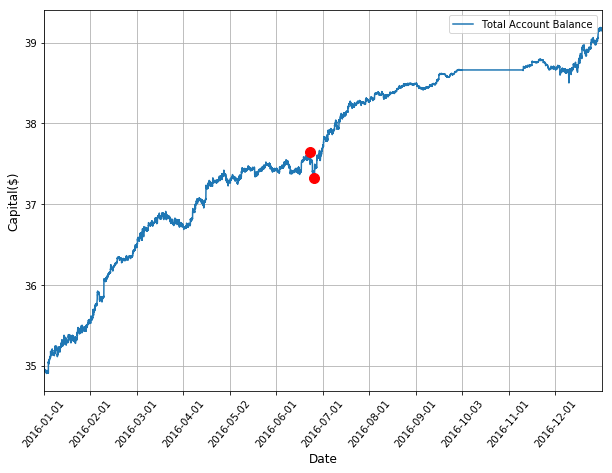

In [24]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  profitable_pairs, ticker_segment_dict,
                                                  n_years_test)

In [34]:
print('Corrected Annualized SR: {:.2f}'.format(0.3344584726627618*14.31))

Corrected Annualized SR: 4.79


### Approach 3: Keeping only top 10 pairs

In [25]:
sharpe_results_threshold_train_w_costs = np.asarray(sharpe_results_threshold_train_w_costs)
sorted_pairs_indices = np.argsort(sharpe_results_threshold_train_w_costs)[::-1][:10]
top_10_pairs = [pairs[i] for i in sorted_pairs_indices.flatten()]

In [26]:
# sorting by returns seems to give better results

In [27]:
cum_returns_threshold_train_w_costs = np.asarray(cum_returns_threshold_train_w_costs)
sorted_pairs_indices = np.argsort(cum_returns_threshold_train_w_costs)[::-1][:10]
top_10_pairs = [pairs[i] for i in sorted_pairs_indices.flatten()]

In [28]:
results_without_costs, results_with_costs, performance_threshold_test = \
                            trader.apply_trading_strategy(top_10_pairs, 
                                                           'fixed_beta',
                                                            2,#entry_multiplier,
                                                            0,#exit_multiplier,
                                                            test_mode=True,
                                                            train_val_split=train_val_split
                                                           )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 10/10

Average SR:  1.5267003647266715
Annual ROI:  15.176094831100917
90.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  4.5309213531337
Autocorrelation:  0.06227327819844487
Daily Sharpe Ratio 0.2653149453895722
Total number of trades:  30
Positive trades:  27
Negative trades:  3
Max DD period: 13.0 days
Maximum drawdown of portfolio: -1.46%


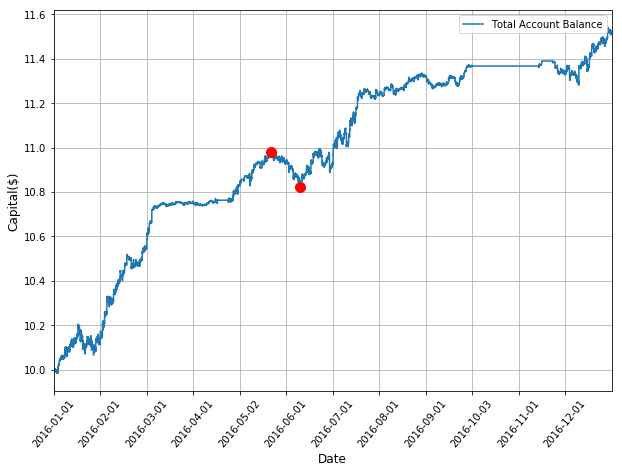

In [29]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  top_10_pairs, ticker_segment_dict,
                                                  n_years_test)

In [35]:
print('Corrected Annualized SR: {:.2f}'.format(0.2653149453895722*14.31))

Corrected Annualized SR: 3.80


# Validate the results

In [30]:
pairs_summary

,Leg1,Leg1_Segmt,Leg2,Leg2_Segmt,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive_trades,negative_trades,sharpe_result,positive_trades_per_pair_pct
0,BCM,Commodities: Broad Market,DJCI,Commodities: Broad Market,-3.181025,0.021110,457,92,0.279985,15,0,4.377431,100.0
1,PICK,Equity: Global Metals & Mining,YMLP,Equity: U.S. MLPs,-4.552308,0.000158,618,673,0.390220,2,0,3.028302,100.0
2,PXE,Equity: U.S. Oil & Gas Exploration & Production,PXI,Equity: U.S. Energy,-3.729752,0.003714,702,214,0.286382,2,0,2.511014,100.0
3,DGL,Commodities: Precious Metals Gold,PPLT,Commodities: Precious Metals Platinum,-3.311093,0.014390,228,2342,0.454413,3,0,1.853256,100.0
4,GLTR,Commodities: Precious Metals,PALL,Commodities: Precious Metals Palladium,-2.976494,0.037149,111,5656,0.483954,1,1,1.328523,50.0
5,DBP,Commodities: Precious Metals,PALL,Commodities: Precious Metals Palladium,-2.886521,0.046938,113,5601,0.493006,1,1,0.884061,50.0
6,DJCI,Commodities: Broad Market,SOYB,Commodities: Agriculture Soybeans,-3.212308,0.019283,297,392,0.330344,1,0,0.643700,100.0
7,BCM,Commodities: Broad Market,SOYB,Commodities: Agriculture Soybeans,-3.111962,0.025681,295,503,0.351337,1,0,0.469970,100.0
8,DGL,Commodities: Precious Metals Gold,GLTR,Commodities: Precious Metals,-3.520620,0.007473,850,214,0.246727,1,1,0.170746,50.0
9,SOYB,Commodities: Agriculture Soybeans,WEAT,Commodities: Agriculture Wheat,-2.959747,0.038828,264,914,0.348989,0,0,0.000000,NaN
